# Quasilinear Diffusion operator

First attempt to calculate the QL diffusion based on a file from WKBeam.

Initially, only stored in rho and the components of N.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import QL_functs_v2 as ql
from CommonModules.input_data import InputData 
from CommonModules.PlasmaEquilibrium import TokamakEquilibrium


In [2]:
filename = '/home/devlamin/Documents/WKBeam_related/Cases_ran_before/TCV72644_1.25/No_fluct/output/L4_binned_QL.hdf5'

In [3]:
WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rho, Theta, Nparallel, Nperp = ql.read_h5file(filename)


In [4]:
filename_Eq = '/home/devlamin/Documents/WKBeam_related/WKBacca_QL/WKBacca_cases/TCV72644_1.25/L4_raytracing.txt'
idata = InputData(filename_Eq)
Eq = TokamakEquilibrium(idata)


 WARNING topfile: assuming psi = 1. at the separatrix. 



In [5]:
print(rho**2)

[1.00000000e-08 2.39693912e-04 9.52592827e-04 2.13870675e-03
 3.79803567e-03 5.93057959e-03 8.53633852e-03 1.16153125e-02
 1.51675014e-02 1.91929053e-02 2.36915243e-02 2.86633582e-02
 3.41084072e-02 4.00266711e-02 4.64181501e-02 5.32828440e-02
 6.06207530e-02 6.84318769e-02 7.67162159e-02 8.54737699e-02
 9.47045389e-02 1.04408523e-01 1.14585722e-01 1.25236136e-01
 1.36359765e-01 1.47956609e-01 1.60026668e-01 1.72569942e-01
 1.85586431e-01 1.99076135e-01 2.13039054e-01 2.27475188e-01
 2.42384537e-01 2.57767101e-01 2.73622880e-01 2.89951874e-01
 3.06754083e-01 3.24029507e-01 3.41778146e-01 3.60000000e-01]


In [6]:


c = 3e8
psi = rho**2
d_npar = Nparallel[1] - Nparallel[0]
d_nperp = Nperp[1] - Nperp[0]
d_theta = Theta[1] - Theta[0]
d_psi = 1/2* (np.diff(psi)[:-1] + np.diff(psi)[1:])
d_psi = np.concatenate(([np.diff(psi)[0]], d_psi, [np.diff(psi)[-1]]))
dV_N = 2*np.pi* Nperp * d_nperp * d_npar
ptV = np.zeros((len(rho), len(Theta)))
X = np.zeros((len(rho), len(Theta)))
Z = np.zeros((len(rho), len(Theta)))

for l, psi_val in enumerate(psi):
    for t, theta_val in enumerate(Theta):
        X[l, t], Z[l, t] = Eq.flux_to_grid_coord(psi_val, theta_val)
        ptV[l, t] = 2*np.pi* 1e-6* d_psi[l] * d_theta * Eq.volume_element_J(theta_val, psi_val)
        



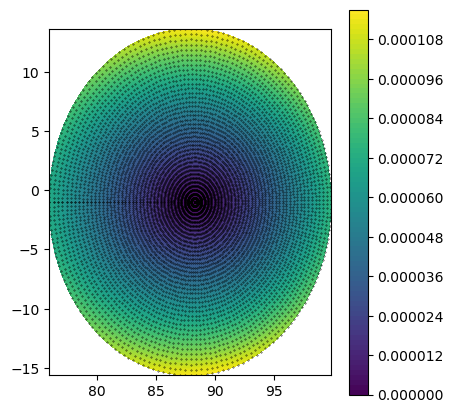

In [7]:

plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
vol = ax.contourf(X, Z, ptV, 100)
ax.scatter(X, Z, c='k', s=0.1)
plt.colorbar(vol)
ax.set_aspect('equal')


In [8]:

Wfct /= ptV[:,:, None, None, None] 
Wfct /= dV_N[None, None, None, :, None]
Wfct /= 2*np.pi * Nperp[None, None, None, :, None]
Wfct /= 2*np.pi * X[:,:, None, None, None]/100
Absorption /= ptV[:,:, None, None, None]
Absorption /= dV_N[None, None, None, :, None]
Absorption /= 2*np.pi * Nperp[None, None, None, :, None]
Absorption /= 2*np.pi * X[:,:, None, None, None]/100 # Averages over refractive index perp angle and toroidal angle
Wfct *= 4*np.pi /c * 1e6


In [9]:
Wfct_maxdens = np.amax(Wfct)
print('Wfct_maxdens:', Wfct_maxdens)

Wfct_maxdens: 2014.947272152963


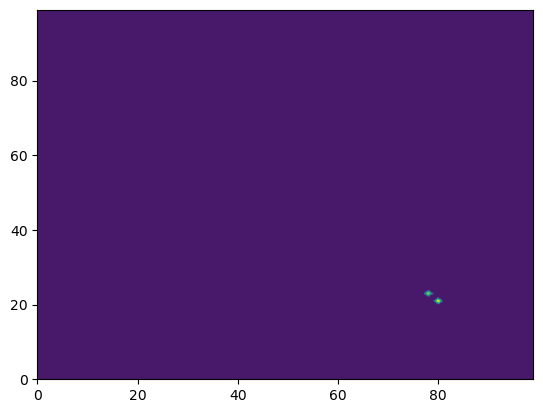

In [10]:
plt.contourf(Wfct[10, 50, :, :, 0])

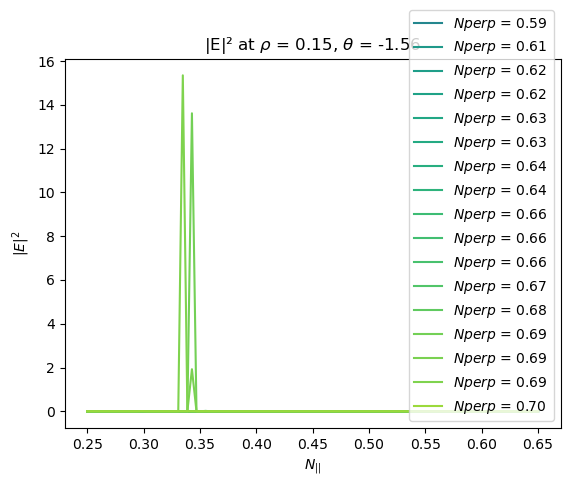

In [11]:
colors = plt.cm.get_cmap('viridis')(np.linspace(0,1,len(Nperp)))

for i in range(len(Nperp)):
    if Wfct[10, 50, :, i, 0].max() > 1e-4:
        plt.plot(Nparallel, Wfct[10, 50, :, i, 0], label=rf'$Nperp$ = {Nperp[i]:.2f}', color=colors[i])
plt.title(rf'|E|² at $\rho$ = {rho[10]:.2f}, $\theta$ = {Theta[50]:.2f}')
plt.xlabel(r'$N_{||}$')
plt.ylabel(r'$|E|^2$')
#plt.xlim(-0.55, -0.1)
plt.legend(loc='lower right')

In [12]:
beam_mask = np.where(Wfct < 1e-4*Wfct_maxdens, False, True)

Wfct = np.where(beam_mask, Wfct, np.nan)

percentage_filled_Wfct = Wfct[beam_mask].size / Wfct.size * 100
print(f'{percentage_filled_Wfct:.2f}% of the phase space is occupied.')

Vel_par = np.where(beam_mask, EnergyFlux[:, :, :, :, 0, :] / Wfct, np.nan)
Vel_perp = np.where(beam_mask, EnergyFlux[:, :, :, :, 1, :] / Wfct, np.nan)


Vel = np.sqrt(Vel_par**2 + Vel_perp**2)


0.34% of the phase space is occupied.


In [13]:
Nparpar, Nperper = np.meshgrid(Nparallel, Nperp, indexing='ij')

N = np.sqrt(Nparpar**2 + Nperper**2)

/tmp/ipykernel_10149/2061229585.py:1: RuntimeWarning: Mean of empty slice
  N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(Theta))] for i in range(len(rho))])


Text(0.5, 1.0, 'Percentage of N-space filled')

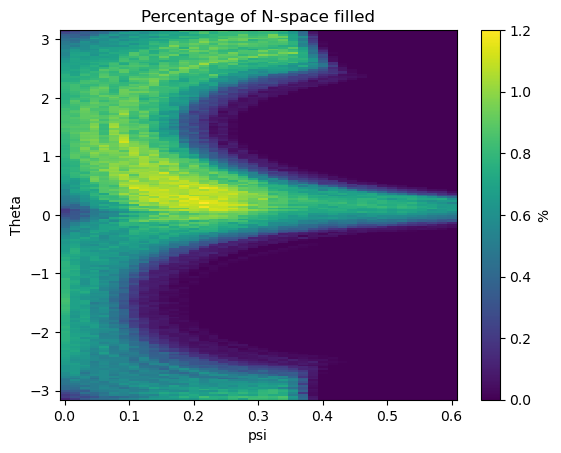

In [14]:
N_avg = np.array([[np.nanmean(N[beam_mask[i, j, :, :, 0]]) for j in range(len(Theta))] for i in range(len(rho))])
N_avg_psi = np.nanmean(N_avg, axis=1)
percentage_filled = np.array([[N[beam_mask[i, j, :, :, 0]].shape[0] / N.size for j in range(len(Theta))] for i in range(len(rho))])

fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.pcolormesh(rho, Theta, 100*percentage_filled.T)

plt.colorbar(p1, label='%')
ax.set_xlabel('psi')
ax.set_ylabel('Theta')
ax.set_title('Percentage of N-space filled')



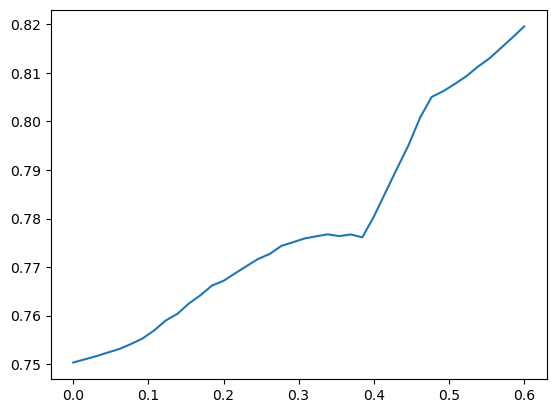

In [15]:
plt.plot(rho, N_avg_psi, label='N_avg')

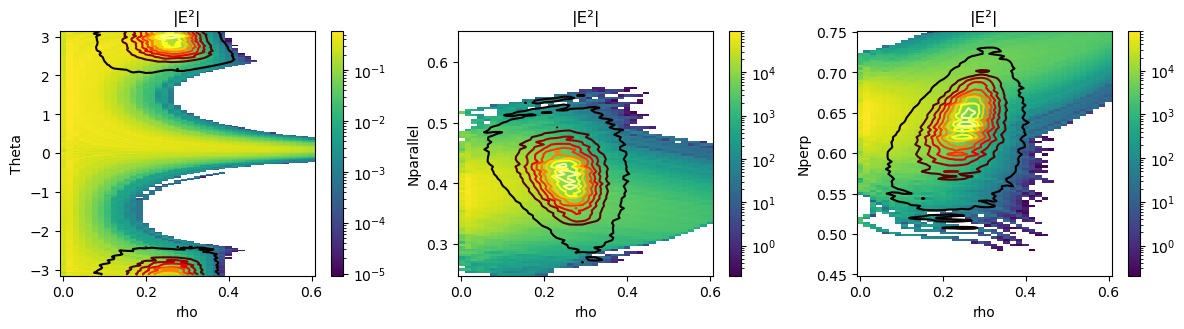

In [16]:
Wfct_rho_Theta = ql.sum_over_dimensions(Wfct*dV_N[None, None, None, :, None], [-3, -2])

Wfct_rho_Nparallel = ql.sum_over_dimensions(Wfct, [-4, -2])
Wfct_rho_Nperp = ql.sum_over_dimensions(Wfct, [-4, -3])


plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2, 3, 1)
plot1 = ax1.pcolormesh(rho, Theta, Wfct_rho_Theta[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot1)
Absorption = np.where(beam_mask, Absorption, np.nan)
Abs_rho_Theta = ql.sum_over_dimensions(Absorption*d_npar*2*np.pi*d_nperp*Nperp[None, None, None, :, None], [-3, -2])
Abs_max= np.nanmax(Abs_rho_Theta[:, :, 0])
ax1.contour(rho, Theta, Abs_rho_Theta[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
#ax1.set_facecolor('white')
ax1.set_xlabel('rho')
ax1.set_ylabel('Theta')
ax1.set_title('|E²|')


ax2 = plt.subplot(2, 3, 2)
plot2 = ax2.pcolormesh(rho, Nparallel, Wfct_rho_Nparallel[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot2)
Abs_rho_Nparallel = ql.sum_over_dimensions(Absorption, [-4, -2])
Abs_max= np.nanmax(Abs_rho_Nparallel[:, :, 0])
ax2.contour(rho, Nparallel, Abs_rho_Nparallel[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
ax2.set_xlabel('rho')
ax2.set_ylabel('Nparallel')
ax2.set_title('|E²|')

ax3 = plt.subplot(2, 3, 3)
plot3 = ax3.pcolormesh(rho, Nperp, Wfct_rho_Nperp[:, :, 0].T, norm=LogNorm())
plt.colorbar(plot3)
Abs_rho_Nperp = ql.sum_over_dimensions(Absorption, [-4, -3])
Abs_max= np.nanmax(Abs_rho_Nperp[:, :, 0])
ax3.contour(rho, Nperp, Abs_rho_Nperp[:, :, 0].T, levels=np.linspace(Abs_max/100, Abs_max, 10), cmap='hot')
ax3.set_xlabel('rho')
ax3.set_ylabel('Nperp')
ax3.set_title('|E²|')

"""
ax4 = plt.subplot(2, 3, 4)
Vel_par_rho_Theta = ql.sum_over_dimensions(Vel_par, [-3, -2])
Vel_perp_rho_Theta = ql.sum_over_dimensions(Vel_perp, [-3, -2])

plot4 = ax4.pcolormesh(rho, Theta, Vel_par_rho_Theta[:, :, 0].T)
plt.colorbar(plot4)
plt.xlabel('rho')
plt.ylabel('Theta')
plt.title('Vel_par')

ax5 = plt.subplot(2, 3, 5)
plot5 = ax5.pcolormesh(rho, Theta, Vel_perp_rho_Theta[:, :, 0].T)   
plt.colorbar(plot5)
plt.xlabel('rho')
plt.ylabel('Theta')
plt.title('Vel_perp')
"""
plt.tight_layout()
plt.show()


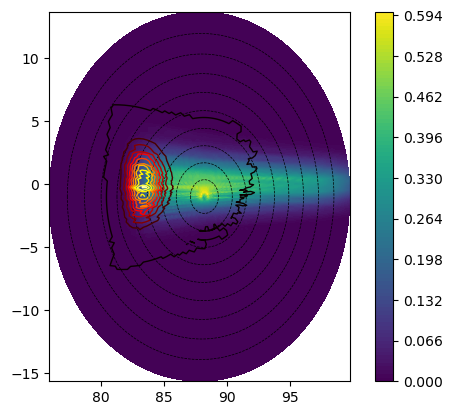

In [17]:
plt.figure()
ax = plt.subplot(111)
beam = ax.contourf(X, Z, Wfct_rho_Theta[:,:,0], 100)
PSI = np.tile(psi, (len(Theta), 1)).T
RHO = np.tile(rho, (len(Theta), 1)).T
ax.contour(X, Z, RHO, levels=10, colors='k', linestyles='dashed', linewidths=0.5)
ax.contour(X, Z, Abs_rho_Theta[:,:,0], levels=10, cmap='hot', linestyles='-', linewidths=1)
plt.colorbar(beam)
ax.set_aspect('equal')
plt.show()


/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


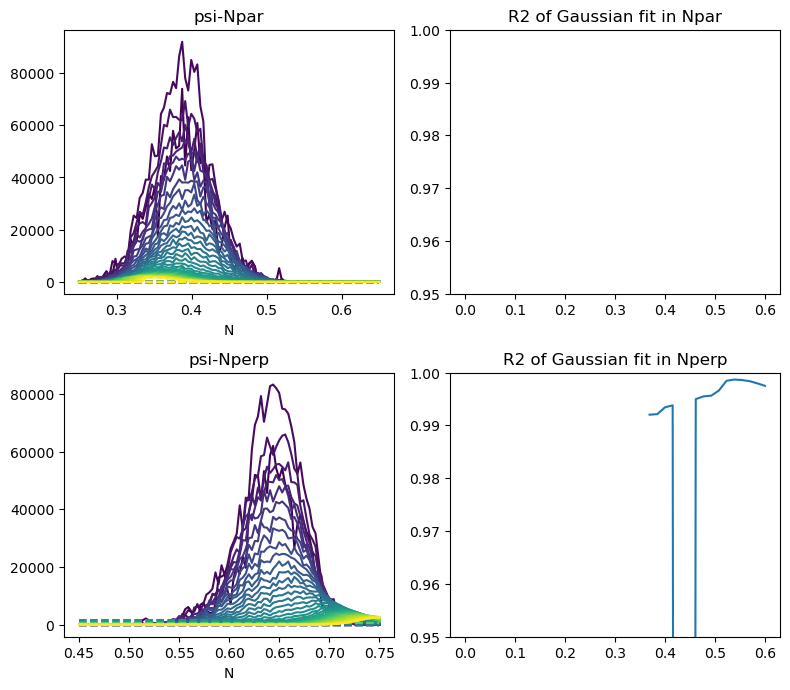

In [18]:
colors = plt.cm.get_cmap('viridis')(np.linspace(0,1,Wfct_rho_Nparallel.shape[0]))

from scipy.optimize import curve_fit

def gaussian(x, a, b, c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def R2(y, y_fit):
    return 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2)

plt.figure(figsize=(8, 10))
firstguess_pos = [-0.35, 0.8]
dimension = ['par', 'perp'] 
for dim in range(2):
    gauss = plt.subplot(3, 2, 2*dim+1)
    if dim == 0:
        N = Nparallel
        Wfct_psi_N = Wfct_rho_Nparallel
    else:
        N = Nperp
        Wfct_psi_N = Wfct_rho_Nperp


    R2s = []
    width_over_avg = []
    for i in range(0, Wfct_psi_N.shape[0], 1):
        gauss.plot(N, Wfct_psi_N[i, :, 0], color=colors[i], label=f'psi={rho[i]:.2f}')
        try:
            popt, pcov = curve_fit(gaussian, N, Wfct_psi_N[i, :, 0], p0=[3e-5, firstguess_pos[dim], 0.1])
        except:
            popt = [np.nan, np.nan, np.nan]
        R2s.append(R2(Wfct_psi_N[i, :, 0], gaussian(N, *popt)))
        width_over_avg.append(popt[2] / popt[1])
        try:
            gauss.plot(N, gaussian(N, *popt), color=colors[i], linestyle='--')
        except:
            pass

        gauss.set_title(f'psi-N{dimension[dim]}')
        gauss.set_xlabel('N')



    r2 = plt.subplot(3, 2, 2*dim+2)
    r2.plot(rho[::1], R2s, label='width/avg')
    r2.set_ylim(.95, 1)
    r2.set_title(f'R2 of Gaussian fit in N{dimension[dim]}')

plt.tight_layout()



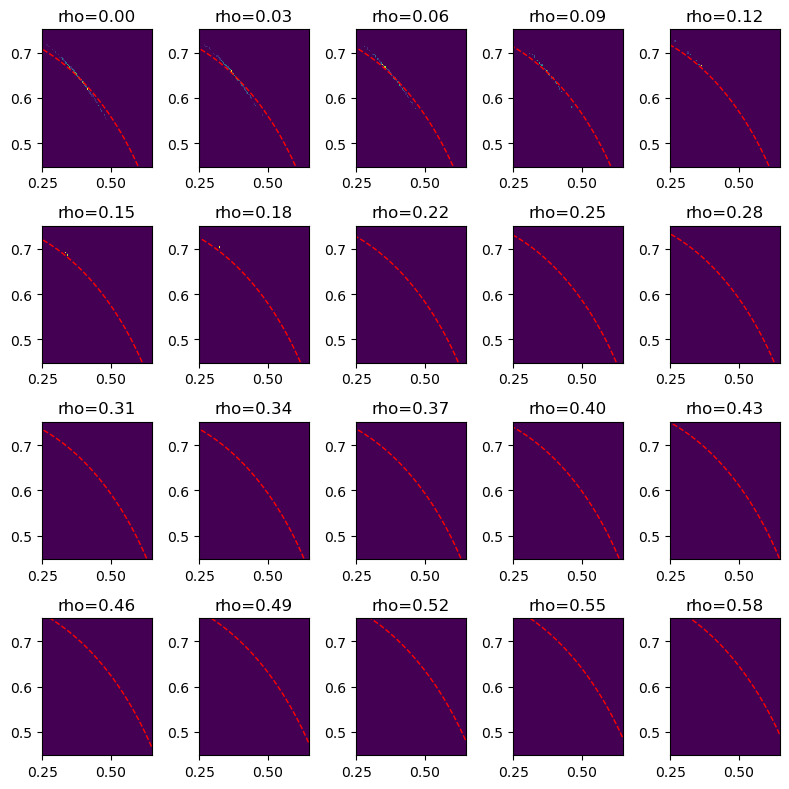

In [19]:
#Wfct_psi_Npar_Nperp = ql.sum_over_dimensions(Wfct, [-4])
Wfct_psi_Npar_Nperp = Wfct[:, 50, :, :, :]
Wfct_nonNan = np.where(np.isnan(Wfct_psi_Npar_Nperp), 0, Wfct_psi_Npar_Nperp)
NPAR, NPERP = np.meshgrid(Nparallel, Nperp, indexing='ij')
N_norm = np.sqrt(NPAR**2 + NPERP**2)
plt.figure(figsize=(8, 8))
for i in range(0, Wfct_nonNan.shape[0], 2):

    
    plt.subplot(4, 5, i//2+1)
    plt.pcolormesh(Nparallel, Nperp, Wfct_nonNan[i, :, :, 0].T)
    plt.contour(NPAR, NPERP, N_norm, [N_avg_psi[i]], colors='r', linestyles='dashed', linewidths=1)
    plt.title(f'rho={rho[i]:.2f}')

plt.tight_layout()
    
    